In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'

In [2]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(f'{ROOT_DIR}/code/helper')
import OTCost as ot
import importlib
importlib.reload(ot)
from sklearn.preprocessing import normalize, StandardScaler
import copy
from emnist import extract_training_samples
from torch.utils.data import Dataset
import pickle
import random
import os

## Load data

In [ ]:
def load_data(dataset, cost):
    if dataset == 'Synthetic':
        cost = "{:.2f}".format(cost)
        d1 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_1_{cost}.csv',sep = ' ', names = [i for i in range(13)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_2_{cost}.csv', sep = ' ', names = [i for i in range(13)])
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values
    
    elif dataset == 'Credit':
        cost = "{:.2f}".format(cost)
        d1 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_1_{cost}.csv',sep = ' ', names = [i for i in range(29)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_2_{cost}.csv', sep = ' ', names = [i for i in range(29)])
        d1 = d1.sample(n=500)
        d2 = d2.sample(n=500)
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values
    
    elif dataset == 'Weather':
        X1,  y1,  X2, y2 = load_data_weather(cost)

    elif dataset == 'EMNIST':
        cost = "{:.2f}".format(cost)
        d1 = np.load(f'{ROOT_DIR}/data/{dataset}/data_1_{cost}.npz')
        d2 = np.load(f'{ROOT_DIR}/data/{dataset}/data_2_{cost}.npz')

        X1, y1 = d1['data'], d1['labels']
        idx = np.random.choice(np.arange(X1.shape[0]), 500, replace=False)
        X1, y1 = X1[idx], y1[idx]
        X1 = X1.reshape(28*28,-1)

        X2, y2 = d2['data'], d2['labels']
        idx = np.random.choice(np.arange(X2.shape[0]), 500, replace=False)
        X2, y2 = X2[idx], y2[idx]
        X2 = X2.reshape(28*28,-1)

    elif dataset == 'CIFAR':
        cost = "{:.2f}".format(cost)
        X1, X2, y1, y2 = load_cifar_embeddings(cost)

    elif dataset == 'IXITiny':
        X1 = load_data_ixitiny(cost[0])
        X2 = load_data_ixitiny(cost[1])
        return {"1":X1, "2":X2}
    
    elif dataset == 'ISIC':
        X1, y1 = load_data_isic(cost[0])
        X2, y2 = load_data_isic(cost[1])
        
    return {"1":X1, "2":X2}, {"1":y1, "2":y2}

def load_data_weather(costs):
     weather_df = load_all_weather()
     return dictionaryCreator(weather_df, costs, n = 5000)

def load_all_weather():
    DATA_DIR = f'{ROOT_DIR}/data/Weather'
    ##load dataset
    df = pd.read_csv(f'{DATA_DIR}/shifts_canonical_train.csv', nrows = 20000)
    df[((df['climate'] == 'tropical') & (df['fact_temperature'] > 25)) | 
        ((df['climate'] == 'mild temperate') & ((df['fact_temperature'] > 10) & (df['fact_temperature'] < 25))) |
        (df['climate'] == 'dry') & ((df['fact_temperature'] > 5) & (df['fact_temperature'] < 25))]
    df_snow = pd.read_csv(f'{DATA_DIR}/shifts_canonical_eval_out.csv', nrows = 20000)
    df_snow = df_snow[df_snow['fact_temperature'] < 10]
    df = pd.concat([df, df_snow])
    df.dropna(inplace = True)
    return df

def extractData(df, climate, n):
    df = df[df['climate'].isin(climate)]
    ind = np.random.choice(df.shape[0], n)
    X = df.iloc[ind, 6:]
    y = df.iloc[ind, 5]
    return X.values, y.values

def dictionaryCreator(df, climates, n = 500):
    ##wrangle to dictionary for OT cost calculation
    X1, y1 = extractData(df, climates[0],n)
    scaler = StandardScaler()
    X1_normalized = scaler.fit_transform(X1)   
    X2, y2 = extractData(df, climates[1],n)
    X2_normalized = scaler.transform(X2)  
   
    return X1_normalized,  y1,  X2_normalized, y2


class EmbeddedImagesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, embedding, label, coarse_label = self.data[idx]
        return image, embedding, label, coarse_label
    
def extract_by_labels(dataset, target_labels, label_type = 'fine'):
    extracted_data = []
    for image, embedding, fine_label, coarse_label in dataset:
        if label_type == 'fine':
            label = fine_label
        else:
            label = coarse_label
        if label in target_labels:
            extracted_data.append((image, embedding, fine_label, coarse_label))
    return EmbeddedImagesDataset(extracted_data)

def get_datasets(dataset, labels_extract, label_type = 'fine'):
    d1 = extract_by_labels(dataset, labels_extract[0], label_type)
    d2 = extract_by_labels(dataset, labels_extract[1], label_type)
    return d1, d2

def sampler(dataset, num_samples):
    indices = random.sample(range(len(dataset)), num_samples)
    sampled_data = [dataset[i] for i in indices]
    embs = np.array([entry[1] for entry in sampled_data])
    label = np.array([entry[2] for entry in sampled_data])
    return embs, label

def load_cifar_embeddings(cost):
    labels = {'0.08': [[x for x in range(10)], [x for x in range(10)]],
            '0.21': [[11,98,29,73, 78, 49, 97, 51, 55, 92], [11,98,29,73, 78, 49, 42, 83, 72, 82]],
            '0.30':[[11,50,78,1,92, 78, 49, 97, 55, 16, 14], [11, 36, 29, 73, 82, 78, 49, 42, 12, 23, 51]],
            '0.38':[[11,50,78,8,92,2,49,98,89,3], [17, 36, 30, 73, 83,28, 34, 42, 10, 20]]}
            
    labels_extract = labels[cost]
    with open(f'{ROOT_DIR}/data/CIFAR/cifar_{1000}_emb.pkl', 'rb') as f:
        data= pickle.load(f)
    d1, d2 = get_datasets(data, labels_extract)
    num_samples = 500
    X1, y1 =  sampler(d1, num_samples)
    X2, y2 =  sampler(d2, num_samples)
    return X1, X2, y1, y2

def load_data_ixitiny(site):
    files = os.listdir(f'{ROOT_DIR}/data/IXITiny/embedding')
    files_site = [file for file in files if site in file]
    embeddings = []
    for file in files_site:
        emb = np.load(f'{ROOT_DIR}/data/IXITiny/embedding/{file}')
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    return embeddings

def load_data_isic(site):
    files = pd.read_csv(f'{ROOT_DIR}/data/ISIC/site_{site}_files_used.csv')
    files = files.sample(500)
    label_counts = files['label'].value_counts()
    selected_labels = label_counts[label_counts > 30].index
    filtered_files = files[files['label'].isin(selected_labels)]
    files_used  = list(filtered_files['image'].values)
    labels_used = list(filtered_files['label'].values)
    embeddings = []
    for file in files_used:
        emb = np.load(f'{ROOT_DIR}/data/ISIC/embedding/center_{site}_{file}.npy')
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    return embeddings, np.array(labels_used)

In [8]:
def grapher(dataset, df, save = True):
    for i in range(1, df.shape[0]):
        sns.lineplot( x= df.iloc[0], y =df.iloc[i], alpha = 0.8, marker = 'o', label = df.index[i])
    plt.plot(np.linspace(0.1, 0.42, 100), np.linspace(0.1, 0.42, 100), linestyle = '--', alpha = 0.5, label = 'Perfect agreement', color = 'black')
    plt.axhline(0.5, label = 'Random coupling', alpha = 0.5, linestyle = 'dotted', color = 'black')
    plt.xlabel('cost at epsilon =1e-3', fontsize = 12)
    plt.ylabel(f'Calculated cost', fontsize = 12)
    plt.legend(bbox_to_anchor=(1, 1), title="epsilon")
    plt.xticks()
    plt.yticks()
    if save == True:
        plt.savefig(f'{ROOT_DIR}/results/regularization_param/{dataset}_reg_param.pdf', bbox_inches='tight')
    plt.show()

## Datasets

In [ ]:
importlib.reload(ot)
dataset = 'Synthetic'
costs = [0.03, 0.1, 0.2, 0.3, 0.4, 0.5]
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_synthetic = {}
for cost in costs:
    data, label= load_data(dataset, cost)
    results_synthetic[cost] = []
    for lam in lams:
        ## calculate cost        
        OTCost_label = ot.OTCost(dataset, data, label, lam = lam)
        c = OTCost_label.calculate_ot_cost()
        results_synthetic[cost].append(c)

df = pd.DataFrame(results_synthetic, index = lams)
grapher(dataset, df, save = True)

/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


cost: 0.10
cost: 0.10
cost: 0.11
cost: 0.17
cost: 0.39
cost: 0.44
cost: 0.45
cost: 0.21
cost: 0.21
cost: 0.22
cost: 0.29
cost: 0.43
cost: 0.46
cost: 0.46
cost: 0.31
cost: 0.31
cost: 0.32
cost: 0.38
cost: 0.47
cost: 0.50
cost: 0.50
cost: 0.39
cost: 0.39
cost: 0.40
cost: 0.46
cost: 0.53
cost: 0.55
cost: 0.56


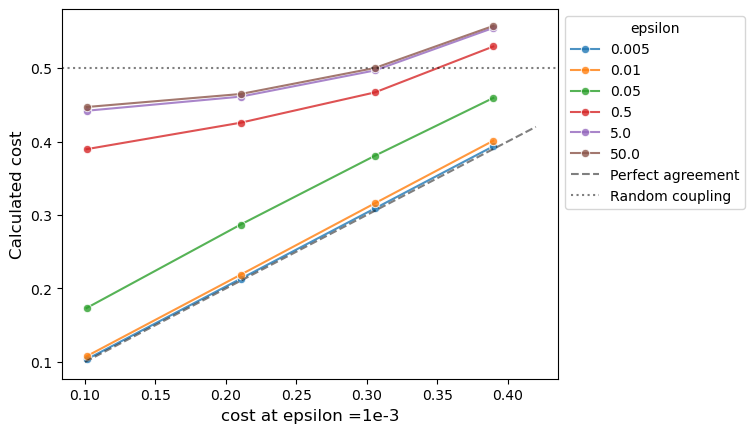

In [10]:
importlib.reload(ot)
costs = [0.12, 0.23, 0.30, 0.40]
dataset = 'Credit'
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_credit = {}
for cost in costs:
    data, label= load_data(dataset, cost)
    results_credit[cost] = []
    for lam in lams:
        ## calculate cost        
        OTCost_label = ot.OTCost(dataset, data, label,  lam = lam)
        c = OTCost_label.calculate_ot_cost()
        results_credit[cost].append(c)

df = pd.DataFrame(results_credit, index = lams)
grapher(dataset, df, save = True)


In [ ]:
importlib.reload(ot)
dataset = 'Weather'
costs = [0.11, 0.19, 0.3, 0.4, 0.48]
climates = [[['tropical', 'mild temperate'],['tropical', 'mild temperate']],
            [['tropical', 'mild temperate'], ['dry', 'mild temperate']],
            [['tropical', 'mild temperate'], ['dry']],
            [['tropical', 'mild temperate'], ['snow', 'dry']],
            [['tropical', 'mild temperate'],['snow']]]
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_weather = {}
for cost, climate in zip(costs, climates):
    data, label= load_data(dataset, climate)
    results_weather[cost] = []
    for lam in lams:
        ## calculate cost        
        OTCost_label = ot.OTCost(dataset, data, label,  lam = lam)
        c = OTCost_label.calculate_ot_cost()
        results_weather[cost].append(c)

df = pd.DataFrame(results_weather, index = lams)
grapher(dataset, df, save = True)


KeyboardInterrupt: 

In [12]:
importlib.reload(ot)
costs = [0.11,0.19,0.25,0.34,0.39]
dataset = 'EMNIST'
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_emnist = {}
for cost in costs:
    data, label= load_data(dataset, cost)
    results_emnist[cost] = []
    for lam in lams:
        ## calculate cost        
        OTCost_label = ot.OTCost(dataset, data, label,  lam = lam)
        c = OTCost_label.calculate_ot_cost()
        results_emnist[cost].append(c)

df = pd.DataFrame(results_emnist, index = lams)
grapher(dataset, df, save = True)


cost: 0.04
cost: 0.04
cost: 0.04
cost: 0.08
cost: 0.15
cost: 0.17
cost: 0.17
cost: 0.05
cost: 0.05
cost: 0.05
cost: 0.09
cost: 0.16
cost: 0.18
cost: 0.18
cost: 0.06
cost: 0.06
cost: 0.06
cost: 0.10
cost: 0.16
cost: 0.18
cost: 0.18
cost: 0.07
cost: 0.07
cost: 0.07
cost: 0.11
cost: 0.17
cost: 0.19
cost: 0.19
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenera

In [ ]:
importlib.reload(ot)
costs = [0.08, 0.21, 0.30, 0.38]
indices =  [
            [[x for x in range(10)], [x for x in range(10)]],
            [[11,98,29,73, 78, 49, 97, 51, 55, 92], [11,98,29,73, 78, 49, 42, 83, 72, 82]],
            [[11,50,78,1,92, 78, 49, 97, 55, 16, 14], [11, 36, 29, 73, 82, 78, 49, 42, 12, 23, 51]],
            [[11,50,78,8,92,2,49,98,89,3], [17, 36, 30, 73, 83,28, 34, 42, 10, 20]]
            ]
dataset = 'CIFAR'
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_cifar = {}
for ind, cost in zip(indices, costs):
    d1, d2 = get_datasets(data,ind)
    x1, y1 =  sampler(d1)
    x2, y2 =  sampler(d2)
    results_cifar[cost] = []
    for lam in lams:
        ## calculate cost        
        OTCost_label = ot.OTCost(dataset, data, label,  lam = lam)
        c = OTCost_label.calculate_ot_cost()
        results_cifar[cost].append(c)

df = pd.DataFrame(results_cifar, index = lams)
grapher(dataset, df, save = True)


In [ ]:
DATASET = 'IXITiny'
DATA_DIR = f'{ROOT_DIR}/data/{DATASET}'
files = os.listdir(f'{DATA_DIR}/embedding')
sites = ['Guys', 'HH', 'IOP']
site_samples = {}
site_embeddings = {}
for site in sites:
    site_samples[site] = [file for file in files if site in file]

for site, files in site_samples.items():
    embeddings = [np.load(f'{DATA_DIR}/embedding/{file}') for file in files]
    site_embeddings[site] = np.array(embeddings) 


importlib.reload(ot)
costs = [0.08, 0.21, 0.30, 0.38]
indices =  [['Guys', 'HH'],
            ['Guys', 'IOP'],
            ['HH', 'IOP']]
dataset = 'IXITiny'
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_ixitiny = {}
for ind, cost in zip(indices, costs):
    X1, X2 = site_embeddings[ind[0]][:], site_embeddings[ind[1]][:]
    data = {'1': X1, '2': X2}
    labels = {'1': np.ones(X1.shape[0]), '2': np.ones(X2.shape[0])}
    results_ixitiny[cost] = []
    for lam in lams:
        ## calculate cost        
        OTCost_label = ot.OTCost(dataset, data, label,  lam = lam)
        c = OTCost_label.calculate_ot_cost()
        results_ixitiny[cost].append(c)

df = pd.DataFrame(results_ixitiny, index = lams)
grapher(dataset, df, save = True)


In [ ]:
DATASET = 'ISIC'
DATA_DIR = f'{ROOT_DIR}/data/{DATASET}'
##Load labels
labels = pd.read_csv(f'{DATA_DIR}/ISIC_2019_Training_GroundTruth.csv')
def create_category(row):
    for idx, value in enumerate(row):
        if value == 1:
            return idx
    return None

labels['label'] = labels.apply(create_category, axis=1) - 1
labels = labels[['image', 'label']]
labels.set_index('image', inplace = True)

NUM_SAMPLES = 2000
files = os.listdir(f'{DATA_DIR}/embedding')
sites = [i for i in range(6)]
site_samples = {}
site_embeddings = {}
site_labels = {}
for site in sites:
    sites_files = [file for file in files if f'center_{site}' in file]
    sites_files = np.random.choice(sites_files, size = NUM_SAMPLES)
    site_samples[site] = sites_files
    names = [f.split(f'center_{site}_')[-1].split('.npy')[0] for f in sites_files]
    labels_site = labels.loc[names]
    site_labels[site] = labels_site['label'].values

for site, files in site_samples.items():
    embeddings = [np.load(f'{DATA_DIR}/embedding/{file}') for file in files]
    site_embeddings[site] = np.array(embeddings)

def create_dictionaries(site_embeddings, site_labels, sites, NUM_SAMPLES = 500):
    data = {'1': site_embeddings[sites[0]][:NUM_SAMPLES], '2' :site_embeddings[sites[1]][:NUM_SAMPLES]}
    labels = {'1': site_labels[sites[0]][:NUM_SAMPLES], '2': site_labels[sites[1]][:NUM_SAMPLES]}
    data, labels = remove_rare_labels(data, labels, min_count = 30)
    return data, labels

#Function is needed as estimating label cost with fewer data points leads to degeneracy
def remove_rare_labels(data, labels, min_count):
    for key in labels:
        unique_labels, counts = np.unique(labels[key], return_counts=True)
        labels_to_remove = unique_labels[counts <= min_count]
        mask = np.isin(labels[key], labels_to_remove, invert=True)
        labels[key] = labels[key][mask]
        data[key] = data[key][mask]
    return data, labels

importlib.reload(ot)
site_pairs = [(2,2), (2,0), (2,3), (2,1), (1,3)]
results = {}
nums = [200, 400, 600, 800, 999]
dataset = 'ISIC'
lams = [1e-3, 5e-3, 1e-2, 5e-2, 5e-1, 5, 50]
results_isic = {}
for ind, cost in zip(site_pairs, costs):
    results_isic[cost] = {}
    for lam in lams:
        importlib.reload(ot)
        if ind[0] != ind[1]:
            data, labels = create_dictionaries(site_embeddings, site_labels, ind)
            ISIC_OTCost_label = ot.OTCost(DATASET, data, labels)
            cost = ISIC_OTCost_label.calculate_ot_cost()
            results_isic[cost].append(c)
        else:
            NUM_SAMPLES = 500
            data = {'1': site_embeddings[ind[0]][:NUM_SAMPLES], '2' :site_embeddings[ind[0]][NUM_SAMPLES:NUM_SAMPLES*2]}
            labels = {'1': site_labels[ind[0]][:NUM_SAMPLES], '2': site_labels[ind[0]][NUM_SAMPLES:NUM_SAMPLES*2]}
            data, labels = remove_rare_labels(data, labels, min_count = 30)
            OTCost_label = ot.OTCost(DATASET, data, labels)
            cost = OTCost_label.calculate_ot_cost()
            results_isic[cost].append(c)